# Import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.utils import to_categorical
# import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [3]:
! pip install xlsxwriter
import xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 4.1 MB/s 


# Utility functions

In [4]:
!pip install matplotx[all]
import matplotx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 2.7 MB/s 


In [5]:
def plotVsRatio(exps, results_df, ds_name, x='ood_ratio', y='acc', thrs=['0.0']):
  stability_df = list()
  
  plt.figure(figsize=(20,8))
  ax = plt.gca()
  ax.set_ylim([0, 110])
  
  # colors = ['#ef5350', '#880e4f', '#7b1fa2', '#7e75c2', '#18237e', '#90caf9', '#43a047', '#ffee58', \
  #           '#827717', '#ff6f00', '#8d6e63', '#607d8b', '#76ff03', '#e040fb', '#212121', '#18ffff']

  for idx, exp in enumerate(exps):
    if 'thr' in exp:
      for thr in thrs:
        condition = (results_df['exp']==exp) & (results_df['ds']==ds_name) & (results_df['thr']==thr)
        label = f'{exp} - {thr}'
        sub_results = results_df.loc[condition]
        sub_results.plot(x=x, y=y, ax=ax, label=label ) #, color=colors[idx])
    else:
      condition = (results_df['exp']==exp) & (results_df['ds']==ds_name)
      label = exp
      sub_results = results_df.loc[condition]
      sub_results.plot(x=x, y=y, ax=ax, label=label) #, color=colors[idx])

    mean = round(sub_results[y].mean(), 2)
    std = round(sub_results[y].std(), 2)
    stability_df.append([label, mean, std])

  matplotx.line_labels()
  
  stability_df= pd.DataFrame(stability_df, columns=['exp', 'mean', 'std'])

  display(stability_df)

In [6]:
def plotVsThr(exps, results_df, ds_name, x='thr', y='acc', ratios=['0']):
  stability_df = list()
  is_acc = 'acc' in y
  is_sens = 'sens' in y
  is_spec = 'spec' in y
  
  plt.figure(figsize=(20,8))
  ax = plt.gca()
  ax.set_ylim([0, 110])
  
  # colors = ['#ef5350', '#880e4f', '#7b1fa2', '#7e75c2', '#18237e', '#90caf9', '#43a047', '#ffee58', \
  #           '#827717', '#ff6f00', '#8d6e63', '#607d8b', '#76ff03', '#e040fb', '#212121', '#18ffff']

  for idx, exp in enumerate(exps):
    for ratio in ratios:
      if is_acc or (is_sens and ratio=='0') or (is_spec and ratio=='100'):
        condition = (results_df['exp']==exp) & (results_df['ds']==ds_name) & (results_df['ood_ratio']==ratio)
        label = f'{exp} - {ratio}'
        sub_results = results_df.loc[condition]
        sub_results.plot(x=x, y=y, ax=ax, label=label ) #, color=colors[idx])

        mean = round(sub_results[y].mean(), 2)
        std = round(sub_results[y].std(), 2)
        stability_df.append([label, mean, std])

  matplotx.line_labels()
  
  stability_df= pd.DataFrame(stability_df, columns=['exp', 'mean', 'std'])

  display(stability_df)

In [7]:
def printDiscData(exps, results_df, ds_name, x='ratio', y='acc', ratios=['0']):
  
  is_acc = 'acc' in y
  is_sens = 'sens' in y
  is_spec = 'spec' in y

  print(f"{ds_name} {y} results")
  disc_acc = list()
  for exp in exps:
    exp_acc = [exp]
    for ratio in ratios:
      if is_acc or (is_sens and ratio=='0') or (is_spec and ratio=='100'):
        condition = (results_df['exp']==exp) & (results_df['ds']==ds_name) & (results_df['ood_ratio']==ratio)
        # label = f'{exp} - {ratio}'
        sub_results = results_df.loc[condition]
        exp_acc.append(round(sub_results[y].mean(), 2))

    disc_acc.append(exp_acc)
    
  if is_acc:
    first_header = ['exp'] + [x for _ in range(len(ratios))]
    second_header = [''] + ratios
    columns=[first_header, second_header]
  else:
    columns=['exp', y]

  disc_acc = pd.DataFrame(disc_acc, columns=columns)
  display(disc_acc)

# Algos plots & results

## load results

In [8]:
data_file = '/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/data/all_results_df_all.pkl'
all_results_num = pd.read_pickle(data_file)
all_results_num

,exp,ds,ood_ratio,thr,acc,acc_balanced,P_macro,P_weighted,R_macro,R_weighted,...,acc_bin,acc_balanced_bin,P_macro_bin,P_weighted_bin,R_macro_bin,R_weighted_bin,F1_macro_bin,F1_weighted_bin,sensitivity,specifity
0,thr,mnist,0,0.0,94.47,92.60,94.79,94.65,92.60,94.47,...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN
1,thr,mnist,5,0.0,89.76,90.17,86.82,87.75,90.17,89.76,...,95.04,50.00,47.52,90.33,50.00,95.04,48.73,92.62,100.00,0.0
2,thr,mnist,10,0.0,85.02,90.14,84.26,81.84,90.14,85.02,...,90.02,50.00,45.01,81.04,50.00,90.02,47.37,85.29,100.00,0.0
3,thr,mnist,15,0.0,80.23,90.06,82.44,76.23,90.06,80.23,...,85.01,50.00,42.51,72.27,50.00,85.01,45.95,78.13,100.00,0.0
4,thr,mnist,20,0.0,75.49,90.04,81.00,70.93,90.04,75.49,...,80.00,50.00,40.00,64.01,50.00,80.00,44.45,71.12,100.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39746,dpmDiscOr,rnd,85,NaN,93.26,54.00,94.01,93.33,54.00,93.26,...,93.33,77.53,96.37,93.81,77.53,93.33,83.62,92.49,55.06,100.0
39747,dpmDiscOr,rnd,90,NaN,95.39,52.86,90.94,95.16,52.86,95.39,...,95.44,76.93,97.59,95.66,76.93,95.44,83.77,94.82,53.85,100.0
39748,dpmDiscOr,rnd,95,NaN,97.80,54.21,91.61,97.61,54.21,97.80,...,97.81,77.38,98.87,97.86,77.38,97.81,84.81,97.50,54.75,100.0
39749,dpmDiscOr,rnd,100,NaN,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,100.0


In [9]:
data_file = '/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/data/all_results_df_all_arabic.pkl'
all_results_arabic = pd.read_pickle(data_file)
all_results_arabic

,exp,ds,ood_ratio,thr,acc,acc_balanced,P_macro,P_weighted,R_macro,R_weighted,...,acc_bin,acc_balanced_bin,P_macro_bin,P_weighted_bin,R_macro_bin,R_weighted_bin,F1_macro_bin,F1_weighted_bin,sensitivity,specifity
0,thr,mnist,0,0.0,81.01,81.01,82.04,82.04,81.01,81.01,...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN
1,thr,mnist,5,0.0,77.50,78.73,77.09,75.90,78.73,77.50,...,95.04,50.00,47.52,90.33,50.00,95.04,48.73,92.62,100.00,0.0
2,thr,mnist,10,0.0,73.82,79.17,75.97,70.84,79.17,73.82,...,90.02,50.00,45.01,81.04,50.00,90.02,47.37,85.29,100.00,0.0
3,thr,mnist,15,0.0,70.34,79.87,75.58,66.52,79.87,70.34,...,85.01,50.00,42.51,72.27,50.00,85.01,45.95,78.13,100.00,0.0
4,thr,mnist,20,0.0,66.80,80.62,75.43,62.49,80.62,66.80,...,80.00,50.00,40.00,64.01,50.00,80.00,44.45,71.12,100.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39746,dpmDiscOr,rnd,85,NaN,89.91,34.42,94.88,90.26,34.42,89.91,...,89.94,66.13,94.72,91.00,66.13,89.94,71.60,87.65,32.25,100.0
39747,dpmDiscOr,rnd,90,NaN,93.24,33.85,94.77,93.24,33.85,93.24,...,93.27,65.92,96.53,93.74,65.92,93.27,72.35,91.65,31.85,100.0
39748,dpmDiscOr,rnd,95,NaN,96.64,33.29,92.60,96.40,33.29,96.64,...,96.65,65.50,98.30,96.77,65.50,96.65,72.80,95.80,30.99,100.0
39749,dpmDiscOr,rnd,100,NaN,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,100.0


## Pick threshold

## define variables

In [10]:
algorithms = ['thr', 'disc', 'thrDiscAnd', 'thrDiscOr', 'dpm', 'dpmDiscAnd', 'dpmDiscOr']
datasets = ['mnist', 'bmnist', 'kmnist', 'fmnist', 'num', 'rnd']
ratios = [str(n) for n in range(0, 101, 5)]
thrs = [str(i/100) for i in range(100)]
thrs.extend(['0.995', '0.999', '1'])
scores_list = ['acc', 'acc_balanced', 'P_macro', 'P_weighted', 'R_macro', 'R_weighted', 'F1_macro', 'F1_weighted', \
               'acc_bin', 'acc_balanced_bin', 'P_macro_bin', 'P_weighted_bin', 'R_macro_bin', 'R_weighted_bin', 'F1_macro_bin', 'F1_weighted_bin', \
               'sensitivity', 'specifity']

results_df_arabic = all_results_arabic.loc[(all_results_arabic['ood_ratio'] != '0') | (all_results_arabic['ds'] == 'clean')].copy()
results_df_num = all_results_num.loc[(all_results_num['ood_ratio'] != '0') | (all_results_num['ds'] == 'clean')].copy()

### Seperator


## Formula test

### Arabic dataset

In [11]:
bin_acc, k_acc, ood_ratio, id_ratio = 0, 0, 0, 0

In [12]:
k_acc_arabic = 0.82
results_df_arab = results_df_arabic.copy()
results_df_arab = results_df_arab.loc[(results_df_arab['ood_ratio']!='0') | ((results_df_arab['ood_ratio']=='0') & (results_df_arab['ds']=="clean"))]

In [13]:
k_acc = k_acc_arabic

#### direct binary ACC

In [14]:
results_df_arab['omega'] = (results_df_arab['acc_bin']/100) * (k_acc)

In [15]:
results_df_arab['formula'] = ((results_df_arab['acc_bin']/100) * (results_df_arab['ood_ratio'].astype(float)/100) + (results_df_arab['acc_bin']/100) * ((1-results_df_arab['ood_ratio'].astype(float)/100) * (k_acc)))

In [16]:
results_df_arab['diff'] = abs(results_df_arab['acc']/100 - results_df_arab['formula'])**2

In [17]:
results_df_arab['diff'].mean(), results_df_arab['diff'].std()

(0.0006307852554222933, 0.0009073858627517065)

In [18]:
results_df_arab['flag'] = (results_df_arab['formula'] >= results_df_arab['omega']) & (results_df_arab['formula'] <= (results_df_arab['acc_bin']/100))

In [19]:
results_df_arab['flag'].value_counts()

True    37873
Name: flag, dtype: int64

In [20]:
results_df_arab[['exp', 'ds', 'ood_ratio', 'acc', 'acc_bin', 'formula']].loc[[1,2,5000,10000,22000,30000]]

,exp,ds,ood_ratio,acc,acc_bin,formula
1,thr,mnist,5,77.50,95.04,0.787882
2,thr,mnist,10,73.82,90.02,0.754368
5000,thr,kmnist,25,63.45,75.14,0.649961
10000,thr,arabic,50,43.78,48.36,0.440076
22000,thrDiscAnd,bmnist,40,65.45,73.39,0.654639
30000,thrDiscOr,bmnist,35,77.58,84.04,0.742073


In [ ]:
sorted_df = results_df.copy()
sorted_df['sorted'] = (sorted_df['omega']+ sorted_df['acc_bin']/100)/2
sorted_df = sorted_df.sort_values(['formula'])

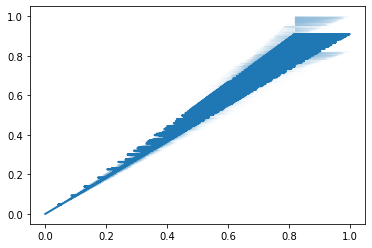

In [ ]:
plt.fill_between(sorted_df['formula'], sorted_df['omega'], sorted_df['acc_bin']/100, alpha=0.5, linewidth=0)
plt.plot(sorted_df['formula'], (sorted_df['omega']+ sorted_df['acc_bin']/100)/2, linewidth=2)

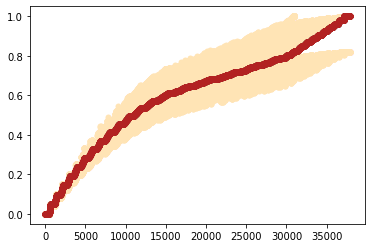

In [ ]:
plt.scatter(np.arange(len(sorted_df)), sorted_df['omega'], color='moccasin', linewidth=0)
plt.scatter(np.arange(len(sorted_df)), sorted_df['acc_bin']/100, color='moccasin', linewidth=0)
plt.scatter(np.arange(len(sorted_df)), sorted_df['formula'], color='firebrick', linewidth=0)

#### Average binary ACC

In [ ]:
bin_acc_arabic_avg = (results_df['acc_bin']/100).mean()

In [ ]:
results_df['A_bin'] = bin_acc_arabic_avg

In [ ]:
results_df['omega'] = bin_acc_arabic_avg * (k_acc)

In [ ]:
results_df['formula'] = (bin_acc_arabic_avg * (results_df['ood_ratio'].astype(float)/100) + bin_acc_arabic_avg * ((1-results_df['ood_ratio'].astype(float)/100) * (k_acc)))

In [ ]:
results_df['diff'] = abs(results_df['acc']/100 - results_df['formula'])

In [ ]:
results_df['diff'].mean(), results_df['diff'].std()

(0.22497340180374525, 0.14965416370388263)

In [ ]:
results_df['flag'] = (results_df['formula'] >= results_df['omega']) & (results_df['formula'] <= bin_acc_arabic_avg)

In [ ]:
results_df['flag'].value_counts()

True    37873
Name: flag, dtype: int64

In [ ]:
results_df[['exp', 'thr', 'ood_ratio','omega', 'formula', 'A_bin']]

,exp,thr,ood_ratio,omega,formula,A_bin
1,thr,0.0,5,0.547881,0.553894,0.668147
2,thr,0.0,10,0.547881,0.559907,0.668147
3,thr,0.0,15,0.547881,0.565921,0.668147
4,thr,0.0,20,0.547881,0.571934,0.668147
5,thr,0.0,25,0.547881,0.577947,0.668147
...,...,...,...,...,...,...
39746,dpmDiscOr,NaN,85,0.547881,0.650107,0.668147
39747,dpmDiscOr,NaN,90,0.547881,0.656120,0.668147
39748,dpmDiscOr,NaN,95,0.547881,0.662134,0.668147
39749,dpmDiscOr,NaN,100,0.547881,0.668147,0.668147


#### Average binary ACC per Algorithm

In [ ]:
A_bin_list = []

for idx, row in tqdm(results_df.iterrows()):
  algo = row['exp']
  thr = row['thr']
  if 'thr' in algo:
    condition = (results_df['exp'] == algo) & (results_df['thr'] == thr)
  else:
    condition = (results_df['exp'] == algo)
  A_bin = results_df.loc[condition]['acc_bin'].mean()
  A_bin_list.append(A_bin)

results_df['A_bin'] = A_bin_list

37873it [03:51, 163.34it/s]


In [ ]:
bin_acc_arabic_avg = (results_df['A_bin'])/100

In [ ]:
results_df['omega'] = bin_acc_arabic_avg * (k_acc)

In [ ]:
results_df['formula'] = (bin_acc_arabic_avg * (results_df['ood_ratio'].astype(float)/100) + bin_acc_arabic_avg * ((1-results_df['ood_ratio'].astype(float)/100) * (k_acc)))

In [ ]:
results_df['diff'] = (results_df['acc']/100 - results_df['formula'])

In [ ]:
results_df['diff'].mean(), results_df['diff'].std()

(0.0011358781233408847, 0.19774153300557618)

In [ ]:
results_df['flag'] = (results_df['formula'] >= results_df['omega']) & (results_df['formula'] <= bin_acc_arabic_avg)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


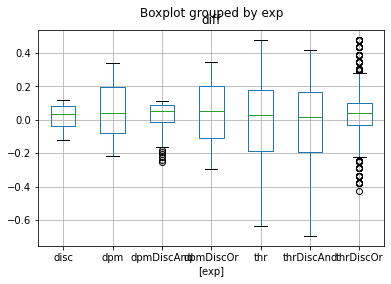

In [ ]:
results_df.boxplot(column='diff', by=['exp'])

#### 0% OOD binary ACC

In [ ]:
# results_df['A_bin'] = np.nan
A_bin_list = []
results_df_clean = results_df_arabic.copy()

for idx, row in tqdm(results_df_clean.iterrows()):
  algo = row['exp']
  thr = row['thr']
  if 'thr' in algo:
    condition = (results_df_clean['exp'] == algo) & (results_df_clean['ds'] == 'clean') & (results_df_clean['thr'] == thr)
  else:
    condition = (results_df_clean['exp'] == algo) & (results_df_clean['ds'] == 'clean')
  A_bin = results_df_clean.loc[condition]['acc_bin'].values[0]
  A_bin_list.append(A_bin)

results_df_clean['A_bin'] = A_bin_list

37873it [05:35, 113.02it/s]


In [ ]:
bin_acc_arabic_avg = (results_df_clean['A_bin'])/100

In [ ]:
results_df_clean['omega'] = bin_acc_arabic_avg * (k_acc)

In [ ]:
results_df_clean['formula'] = (bin_acc_arabic_avg * (results_df_clean['ood_ratio'].astype(float)/100) + bin_acc_arabic_avg * ((1-results_df_clean['ood_ratio'].astype(float)/100) * (k_acc)))

In [ ]:
results_df_clean['diff'] = abs(results_df_clean['acc']/100 - results_df_clean['formula'])

In [ ]:
results_df_clean['diff'].mean(), results_df_clean['diff'].std()

(0.3232156310828294, 0.2576501969822096)

In [ ]:
results_df_clean['flag'] = (results_df_clean['formula'] >= results_df_clean['omega']) & (results_df_clean['formula'] <= bin_acc_arabic_avg)

In [ ]:
results_df_clean['flag'] = (results_df_clean['formula'] >= results_df_clean['acc']/100)

In [ ]:
results_df_clean['flag'].value_counts()

True     22222
False    15651
Name: flag, dtype: int64

In [ ]:
results_df_clean['diff'].mean(), results_df_clean['diff'].std()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


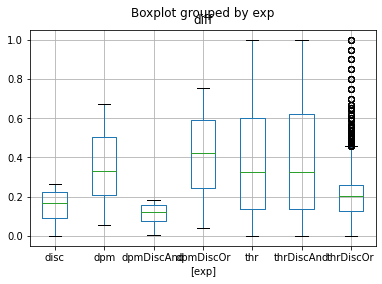

In [ ]:
results_df_clean.boxplot(column='diff', by=['exp'])

#### 0% OOD binary ACC (average)

In [ ]:
# results_df['A_bin'] = np.nan
A_bin_list = []
results_df_clean_avg = results_df_arabic.copy()

for idx, row in tqdm(results_df_clean_avg.iterrows()):
  algo = row['exp']
  thr = row['thr']
  # if 'thr' in algo:
  #   condition = (results_df_clean_avg['exp'] == algo) & (results_df_clean_avg['ds'] == 'clean'))
  # else:
  condition = (results_df_clean_avg['exp'] == algo) & (results_df_clean_avg['ds'] == 'clean')
  A_bin = results_df_clean_avg.loc[condition]['acc_bin'].mean()
  A_bin_list.append(A_bin)

results_df_clean_avg['A_bin'] = A_bin_list

37873it [03:57, 159.49it/s]


In [ ]:
bin_acc_arabic_avg = (results_df_clean_avg['A_bin'])/100

In [ ]:
results_df_clean_avg['omega'] = bin_acc_arabic_avg * (k_acc)

In [ ]:
results_df_clean_avg['formula'] = (bin_acc_arabic_avg * (results_df_clean_avg['ood_ratio'].astype(float)/100) + bin_acc_arabic_avg * ((1-results_df_clean_avg['ood_ratio'].astype(float)/100) * (k_acc)))

In [ ]:
results_df_clean_avg['diff'] = abs(results_df_clean_avg['acc']/100 - results_df_clean_avg['formula'])

In [ ]:
results_df_clean_avg['diff'].mean(), results_df_clean_avg['diff'].std()

(0.3098290688432136, 0.24388552818385126)

In [ ]:
results_df_clean_avg['flag'] = (results_df_clean_avg['formula'] >= results_df_clean_avg['omega']) & (results_df_clean_avg['formula'] <= bin_acc_arabic_avg)

In [ ]:
results_df_clean_avg['flag'] = (results_df_clean_avg['formula'] >= results_df_clean_avg['acc']/100)

In [ ]:
results_df_clean_avg['flag'].value_counts()

True     23698
False    14175
Name: flag, dtype: int64

In [ ]:
results_df_clean_avg['diff'].mean(), results_df_clean_avg['diff'].std()

(0.3098290688432136, 0.24388552818385126)

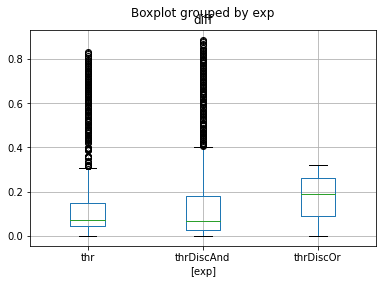

In [ ]:
results_df_clean_avg.loc[(results_df_clean_rnd['thr'] >= 0.9) & (results_df_clean_rnd['thr'] <= 0.99)].boxplot(column='diff', by=['exp'])

#### 0% OOD binary ACC (fully_random)

In [ ]:
# results_df['A_bin'] = np.nan
A_bin_list = []
results_df_clean_rnd = results_df_arabic.copy()

for idx, row in tqdm(results_df_clean_rnd.iterrows()):
  algo = row['exp']
  thr = row['thr']
  # if 'thr' in algo:
  #   condition = (results_df_clean_avg['exp'] == algo) & (results_df_clean_avg['ds'] == 'clean'))
  # else:
  condition = (results_df_clean_rnd['exp'] == algo) & (results_df_clean_rnd['ds'] == 'rnd') & (results_df_clean_avg['ood_ratio'] == '100')
  A_bin = results_df_clean_rnd.loc[condition]['acc_bin'].mean()
  A_bin_list.append(A_bin)

results_df_clean_rnd['A_bin'] = A_bin_list

37873it [05:37, 112.19it/s]


In [ ]:
bin_acc_arabic_avg = (results_df_clean_rnd['A_bin'])/100

In [ ]:
results_df_clean_rnd['omega'] = bin_acc_arabic_avg * (k_acc)

In [ ]:
results_df_clean_rnd['formula'] = (bin_acc_arabic_avg * (results_df_clean_rnd['ood_ratio'].astype(float)/100) + bin_acc_arabic_avg * ((1-results_df_clean_rnd['ood_ratio'].astype(float)/100) * (k_acc)))

In [ ]:
results_df_clean_rnd['diff'] = abs(results_df_clean_rnd['acc']/100 - results_df_clean_rnd['formula'])

In [ ]:
results_df_clean_rnd['diff'].mean(), results_df_clean_rnd['diff'].std()

(0.24327316102861915, 0.19230637153528712)

In [ ]:
results_df_clean_rnd['flag'] = (results_df_clean_rnd['formula'] >= results_df_clean_rnd['omega']) & (results_df_clean_rnd['formula'] <= bin_acc_arabic_avg)

In [ ]:
results_df_clean_rnd['flag'] = (results_df_clean_rnd['formula'] >= results_df_clean_rnd['acc']/100)

In [ ]:
results_df_clean_rnd['flag'].value_counts()

False    20287
True     17586
Name: flag, dtype: int64

In [ ]:
results_df_clean_rnd['diff'].mean(), results_df_clean_rnd['diff'].std()

(0.24327316102861915, 0.19230637153528712)

In [ ]:
results_df_clean_rnd['thr'] = results_df_clean_rnd['thr'].astype(float)

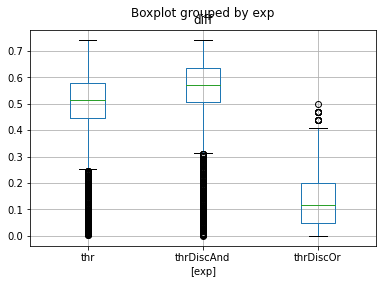

In [ ]:
results_df_clean_rnd.loc[(results_df_clean_rnd['thr'] >= 0.9) & (results_df_clean_rnd['thr'] <1)].boxplot(column='diff', by=['exp'])

In [ ]:
results_df.loc[(results_df['diff']>0) & (results_df['exp']=='thr') & (results_df['thr']=='0.99') & (results_df['ds']=='mnist')]

,exp,ds,ood_ratio,thr,acc,acc_balanced,P_macro,P_weighted,R_macro,R_weighted,...,P_macro_bin,P_weighted_bin,R_macro_bin,R_weighted_bin,F1_macro_bin,F1_weighted_bin,sensitivity,specifity,formula,diff
12573,thr,mnist,0,0.99,60.85,60.86,90.68,93.92,58.76,60.85,...,50.00,100.00,32.48,64.97,39.38,78.77,64.97,NaN,52.632197,8.217803
12574,thr,mnist,5,0.99,63.39,62.84,91.16,89.94,62.84,63.39,...,56.43,95.56,82.01,67.25,51.08,76.42,65.63,98.38,55.117764,8.272236
12575,thr,mnist,10,0.99,65.81,63.45,91.56,87.01,63.45,65.81,...,62.03,92.18,82.19,69.38,59.29,75.51,66.18,98.19,57.522264,8.287736
12576,thr,mnist,15,0.99,68.44,64.40,91.94,85.07,64.40,68.44,...,66.99,89.77,82.63,71.73,65.57,75.77,67.06,98.20,60.151702,8.288298
12577,thr,mnist,20,0.99,71.12,65.52,92.36,83.98,65.52,71.12,...,71.41,88.18,83.15,74.08,70.51,76.67,68.04,98.25,62.825766,8.294234
12578,thr,mnist,25,0.99,73.69,66.65,92.56,83.40,66.65,73.69,...,75.32,87.21,83.68,76.44,74.54,78.02,69.20,98.16,65.553033,8.136967
12579,thr,mnist,30,0.99,76.29,67.94,93.15,83.65,67.94,76.29,...,78.81,86.87,84.28,78.67,77.81,79.55,70.23,98.33,68.212397,8.077603
12580,thr,mnist,35,0.99,78.38,68.60,93.53,84.04,68.60,78.38,...,81.69,86.83,84.63,80.48,80.22,80.90,70.75,98.51,70.545951,7.834049
12581,thr,mnist,40,0.99,80.05,68.74,93.62,84.40,68.74,80.05,...,83.97,86.91,84.70,81.93,81.91,82.02,70.82,98.57,72.594896,7.455104
12582,thr,mnist,45,0.99,81.56,68.67,93.58,84.88,68.67,81.56,...,85.88,87.11,84.64,83.26,83.21,83.12,70.73,98.55,74.563909,6.996091


### Num dataset

In [21]:
bin_acc, k_acc, ood_ratio, id_ratio = 0, 0, 0, 0

In [22]:
k_acc_num = 0.9447
results_df_num = all_results_num.copy()
results_df_num = results_df_num.loc[(results_df_num['ood_ratio']!="0") | ((results_df_num['ood_ratio']=="0") & (results_df_num['ds']=="clean"))]

In [23]:
k_acc = k_acc_num

#### direct binary ACC

In [24]:
results_df_num['omega'] = (results_df_num['acc_bin']/100) * (k_acc)

In [25]:
results_df_num['formula'] = ((results_df_num['acc_bin']/100) * (results_df_num['ood_ratio'].astype(float)/100) + (results_df_num['acc_bin']/100) * ((1-results_df_num['ood_ratio'].astype(float)/100) * (k_acc)))

In [26]:
results_df_num['diff'] = abs(results_df_num['acc']/100 - results_df_num['formula'])**2

In [27]:
results_df_num['diff'].mean(), results_df_num['diff'].std()

(0.00010216611791605458, 0.00018308199902972787)

In [28]:
results_df_num['flag'] = (results_df_num['formula'] >= results_df_num['omega']) & (results_df_num['formula'] <= (results_df_num['acc_bin']/100))

In [29]:
results_df_num['flag'].value_counts()

True    37873
Name: flag, dtype: int64

In [30]:
results_df_num[['exp', 'ds', 'ood_ratio', 'acc', 'acc_bin', 'formula']].loc[[1,2,5000,10000,22000,30000]]

,exp,ds,ood_ratio,acc,acc_bin,formula
1,thr,mnist,5,89.76,95.04,0.900471
2,thr,mnist,10,85.02,90.02,0.855397
5000,thr,kmnist,25,81.34,85.51,0.819635
10000,thr,num,50,83.73,84.73,0.823872
22000,thrDiscAnd,bmnist,40,73.12,76.28,0.737490
30000,thrDiscOr,bmnist,35,87.76,90.89,0.876230


In [ ]:
results_df_num[['exp', 'ds', 'ood_ratio', 'acc', 'acc_bin', 'formula']].loc[[1,2,5000,10000,22000,30000]]

,exp,ds,ood_ratio,acc,acc_bin,formula
1,thr,mnist,5,89.76,95.04,0.900471
2,thr,mnist,10,85.02,90.02,0.855397
5000,thr,kmnist,25,81.34,85.51,0.819635
10000,thr,num,50,83.73,84.73,0.823872
22000,thrDiscAnd,bmnist,40,73.12,76.28,0.737490
30000,thrDiscOr,bmnist,35,87.76,90.89,0.876230


# Plot formula inequality 2

In [ ]:
sorted_df_1 = results_df_num.copy()
# sorted_df_1['sorted'] = (sorted_df_1['omega']+ sorted_df_1['acc_bin']/100)/2
# sorted_df_1 = sorted_df_1.sort_values(['formula'])

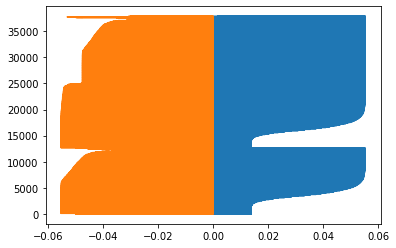

In [ ]:
plt.plot(sorted_df_1['formula'] - sorted_df_1['omega'], np.arange(len(sorted_df_1)))
plt.plot(sorted_df_1['formula'] - sorted_df_1['acc_bin']/100, np.arange(len(sorted_df_1)))

In [ ]:
len(sorted_df_1)

37873

In [ ]:
sorted_df_2 = results_df_arab.copy()
# sorted_df_2['sorted'] = (sorted_df_2['omega']+ sorted_df_2['acc_bin']/100)/2
# sorted_df_2 = sorted_df_2.sort_values(['formula'])

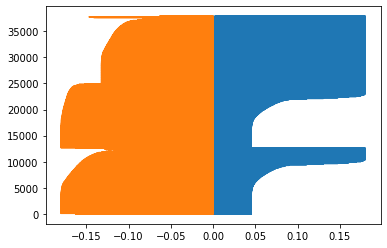

In [ ]:
plt.plot(sorted_df_2['formula'] - sorted_df_2['omega'], np.arange(len(sorted_df_2)))
plt.plot(sorted_df_2['formula'] - sorted_df_2['acc_bin']/100, np.arange(len(sorted_df_2)))

In [ ]:
len(sorted_df_2)

37873

In [ ]:
len(sorted_df_1) + len(sorted_df_2)

75746

In [ ]:
pd.unique(sorted_df_1['thr'])

array(['0.0', '0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07',
       '0.08', '0.09', '0.1', '0.11', '0.12', '0.13', '0.14', '0.15',
       '0.16', '0.17', '0.18', '0.19', '0.2', '0.21', '0.22', '0.23',
       '0.24', '0.25', '0.26', '0.27', '0.28', '0.29', '0.3', '0.31',
       '0.32', '0.33', '0.34', '0.35', '0.36', '0.37', '0.38', '0.39',
       '0.4', '0.41', '0.42', '0.43', '0.44', '0.45', '0.46', '0.47',
       '0.48', '0.49', '0.5', '0.51', '0.52', '0.53', '0.54', '0.55',
       '0.56', '0.57', '0.58', '0.59', '0.6', '0.61', '0.62', '0.63',
       '0.64', '0.65', '0.66', '0.67', '0.68', '0.69', '0.7', '0.71',
       '0.72', '0.73', '0.74', '0.75', '0.76', '0.77', '0.78', '0.79',
       '0.8', '0.81', '0.82', '0.83', '0.84', '0.85', '0.86', '0.87',
       '0.88', '0.89', '0.9', '0.91', '0.92', '0.93', '0.94', '0.95',
       '0.96', '0.97', '0.98', '0.99', '0.995', '0.999', '1', nan],
      dtype=object)

In [ ]:
# [ 313 (103*3 + 4) * 20 * 6 + 313 (clean) ] * 2

In [ ]:
# x=sorted_df_1.loc[(sorted_df_1['ood_ratio']!="0") | ((sorted_df_1['ood_ratio']=="0") & (sorted_df_1['ds']=="clean"))]
# pd.pivot_table(x, values='ood_ratio', index='exp', columns='ds',
#                aggfunc='count')

ds,bmnist,clean,fmnist,kmnist,mnist,num,rnd
exp,,,,,,,
disc,20,1,20,20,20,20,20
dpm,20,1,20,20,20,20,20
dpmDiscAnd,20,1,20,20,20,20,20
dpmDiscOr,20,1,20,20,20,20,20
thr,2060,103,2060,2060,2060,2060,2060
thrDiscAnd,2060,103,2060,2060,2060,2060,2060
thrDiscOr,2060,103,2060,2060,2060,2060,2060


In [ ]:
pd.pivot_table(sorted_df_2, values='thr', index=['exp','ood_ratio'], columns='ds',
               aggfunc='count')

ds                   arabic  bmnist  clean  fmnist  kmnist  mnist    rnd
exp       ood_ratio                                                     
disc      0             NaN     NaN    0.0     NaN     NaN    NaN    NaN
          10            0.0     0.0    NaN     0.0     0.0    0.0    0.0
          100           0.0     0.0    NaN     0.0     0.0    0.0    0.0
          15            0.0     0.0    NaN     0.0     0.0    0.0    0.0
          20            0.0     0.0    NaN     0.0     0.0    0.0    0.0
...                     ...     ...    ...     ...     ...    ...    ...
thrDiscOr 75          103.0   103.0    NaN   103.0   103.0  103.0  103.0
          80          103.0   103.0    NaN   103.0   103.0  103.0  103.0
          85          103.0   103.0    NaN   103.0   103.0  103.0  103.0
          90          103.0   103.0    NaN   103.0   103.0  103.0  103.0
          95          103.0   103.0    NaN   103.0   103.0  103.0  103.0

[147 rows x 7 columns]

In [ ]:
pd.pivot_table(sorted_df_2, values='ood_ratio', index='exp', columns='ds',
               aggfunc='count').sum()

ds
arabic    6260
bmnist    6260
clean      313
fmnist    6260
kmnist    6260
mnist     6260
rnd       6260
dtype: int64

# Plot formula inequality

In [31]:
sorted_df_1 = results_df_num.copy()
sorted_df_1['sorted'] = (sorted_df_1['omega']+ sorted_df_1['acc_bin']/100)/2
sorted_df_1 = sorted_df_1.sort_values(['formula'])

In [32]:
sorted_df_2 = results_df_arab.copy()
sorted_df_2['sorted'] = (sorted_df_2['omega']+ sorted_df_2['acc_bin']/100)/2
sorted_df_2 = sorted_df_2.sort_values(['formula'])

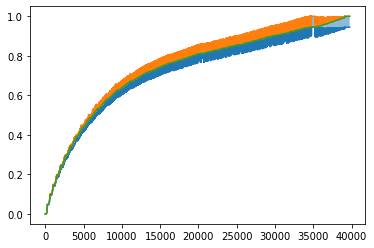

In [ ]:
plt.plot(np.arange(len(sorted_df_1)), sorted_df_1['omega'], 
         np.arange(len(sorted_df_1)), sorted_df_1['acc_bin']/100,
         np.arange(len(sorted_df_1)), sorted_df_1['formula'])
plt.fill_between(np.arange(len(sorted_df_1)), sorted_df_1['omega'], sorted_df_1['acc_bin']/100, alpha=0.5)
plt.show()

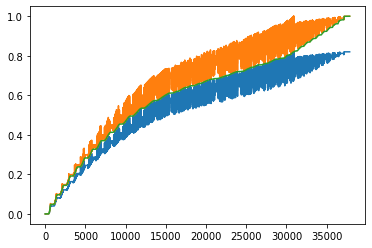

In [ ]:
plt.plot(np.arange(len(sorted_df_2)), sorted_df_2['omega'], 
         np.arange(len(sorted_df_2)), sorted_df_2['acc_bin']/100,
         np.arange(len(sorted_df_2)), sorted_df_2['formula'])
# plt.fill_between(np.arange(len(sorted_df_2)), sorted_df_2['omega'], sorted_df_2['acc_bin'], color='grey', alpha=0.5)
plt.show()

In [ ]:
sorted_df_2.iloc[len(sorted_df_2.index) - 1:, :][['omega', 'acc_bin', 'formula']]

,omega,acc_bin,formula
35220,0.82,100.0,1.0


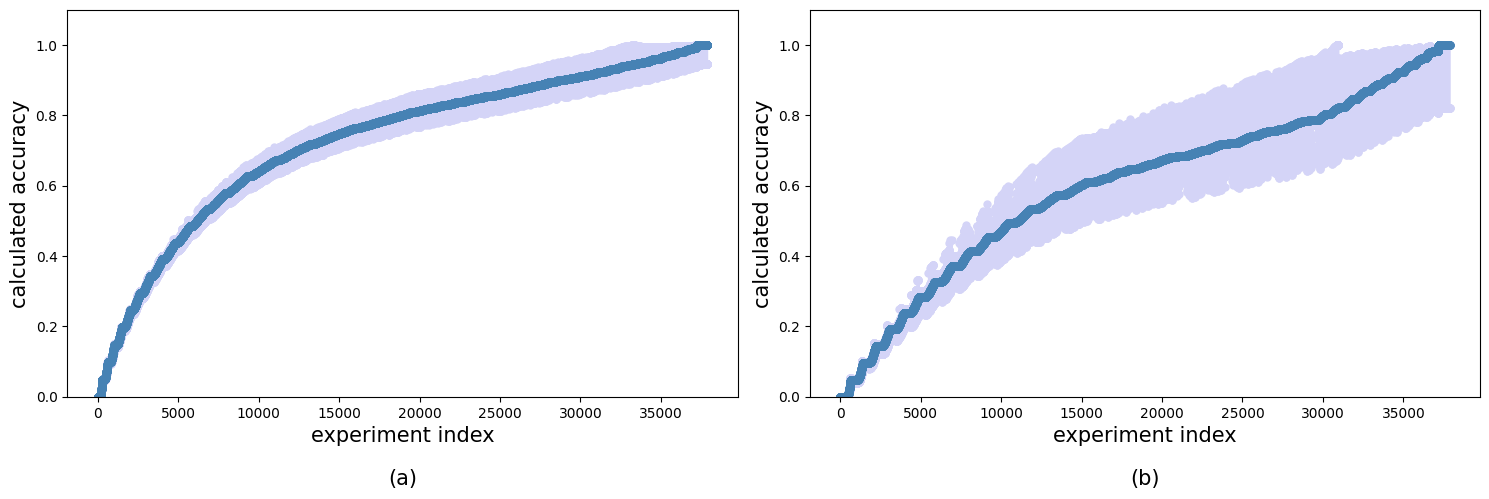

In [35]:
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=100)

ax[0].scatter(np.arange(len(sorted_df_1)), sorted_df_1['omega'], color='#D4D4F7', linewidth=0)
ax[0].scatter(np.arange(len(sorted_df_1)), sorted_df_1['acc_bin']/100, color='#D4D4F7', linewidth=0)
ax[0].fill_between(np.arange(len(sorted_df_1)), sorted_df_1['omega'], sorted_df_1['acc_bin']/100, color='#D4D4F7')
ax[0].scatter(np.arange(len(sorted_df_1)), sorted_df_1['formula'], color='steelblue', linewidth=0)



ax[0].set_ylim([0, 1.1])
ax[0].set_xlabel('experiment index', size=15)
ax[0].set_ylabel('calculated accuracy', size=15)
ax[0].set_title('(a)', y=-0.25, size=15)
# ax.set_xticks(range(0, 11, 10))
# ax[0].set_yticks(range(0, 100, 10)/100)



ax[1].scatter(np.arange(len(sorted_df_2)), sorted_df_2['omega'], color='#D4D4F7', linewidth=0)
ax[1].scatter(np.arange(len(sorted_df_2)), sorted_df_2['acc_bin']/100, color='#D4D4F7', linewidth=0)
ax[1].fill_between(np.arange(len(sorted_df_2)), sorted_df_2['omega'], sorted_df_2['acc_bin']/100, color='#D4D4F7')
ax[1].scatter(np.arange(len(sorted_df_2)), sorted_df_2['formula'], color='steelblue', linewidth=0)


ax[1].set_ylim([0, 1.1])
ax[1].set_xlabel('experiment index', size=15)
ax[1].set_ylabel('calculated accuracy', size=15)
ax[1].set_title('(b)', y=-0.25, size=15)
# ax.set_xticks(range(0, 11, 10))
# ax[1].set_yticks(range(0, 100, 10)/100)

plt.subplots_adjust(left=0.2,bottom=0.2, top = 0.9, right = 0.9)
plt.tight_layout()
plt.savefig('./calculated_acc.png')

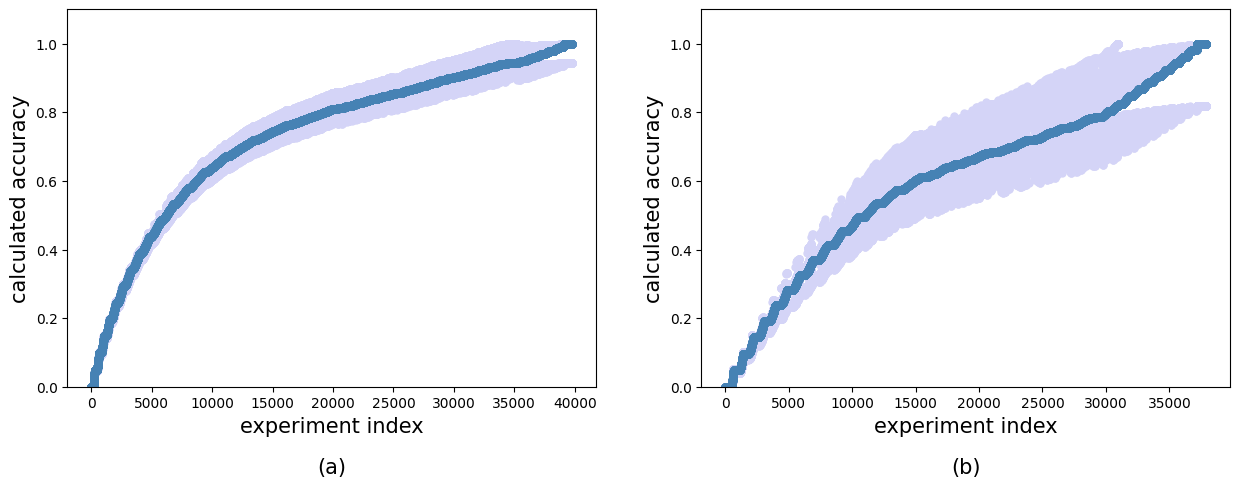

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=100)

ax[0].scatter(np.arange(len(sorted_df_1)), sorted_df_1['omega'], color='#D4D4F7', linewidth=0)
ax[0].scatter(np.arange(len(sorted_df_1)), sorted_df_1['acc_bin']/100, color='#D4D4F7', linewidth=0)
ax[0].scatter(np.arange(len(sorted_df_1)), sorted_df_1['formula'], color='steelblue', linewidth=0)


ax[0].set_ylim([0, 1.1])
ax[0].set_xlabel('experiment index', size=15)
ax[0].set_ylabel('calculated accuracy', size=15)
ax[0].set_title('(a)', y=-0.25, size=15)
# ax.set_xticks(range(0, 11, 10))
# ax[0].set_yticks(range(0, 100, 10)/100)



ax[1].scatter(np.arange(len(sorted_df_2)), sorted_df_2['omega'], color='#D4D4F7', linewidth=0)
ax[1].scatter(np.arange(len(sorted_df_2)), sorted_df_2['acc_bin']/100, color='#D4D4F7', linewidth=0)
ax[1].scatter(np.arange(len(sorted_df_2)), sorted_df_2['formula'], color='steelblue', linewidth=0)


ax[1].set_ylim([0, 1.1])
ax[1].set_xlabel('experiment index', size=15)
ax[1].set_ylabel('calculated accuracy', size=15)
ax[1].set_title('(b)', y=-0.25, size=15)
# ax.set_xticks(range(0, 11, 10))
# ax[1].set_yticks(range(0, 100, 10)/100)

plt.savefig('./calculated_acc.png')